# **Body Part Regression for a sample of series from the NLST collection**

You can find more IDC tutorial notebooks here: https://github.com/ImagingDataCommons/IDC-Examples/tree/master/notebooks

The goal of this notebook is to demonstrate how one can enrich DICOM metadata for CT scans, in particular the body part examined regions. Currently in DICOM files, the BodyPartExamined tag is used to convey which parts of the body were scanned. Unforutnately it is prone to errors, as it may be missing, incomplete or incorrect. 

One way to enhance this it to classify each axial slice as belonging to one or more regions (HEAD, NECK, CHEST, ABDOMEN, PELVIS, LEGS), etc. This information can then be used as preprocessing cropping step, or to aid in the querying of data for AI algorithms. 

A deep learning method has been developed by [Schuhegger 2021](https://arxiv.org/abs/2110.09148) which predicts the body part examined region for each axial slice in a CT volume. We use this trained model to perform inference on a small sample from the National Lung Screening Trial (NLST) collection. We demonstrate how Structured Reports can be created to store the regions for each slice, and upload our results to a DICOM datastore. We then show how these annotations can be viewed using your own OHIF viewer. 

Authors: 
Deepa Krishnaswamy (Brigham and Women's Hospital) and 
Andrey Fedorov (Brigham and Women's Hospital)

Summer 2022

## User input 

You will be able to deploy your own instance of the OHIF viewer. Replace the name wtih your own in the variable `my_ohif_app`. 

In [ ]:
my_ohif_app = 'idc-tester-dk' 

Follow another notebook to make sure your project id is set up. Replace the name with your own in `project_name`, as well as the corresponding `location_id`.

In [ ]:
project_name = 'idc-external-018' 
location_id = 'us-central1'

These are the names of the GCP buckets, dataset and DICOM datastore that we will use to store our results. This is optional for you to change.

In [ ]:
my_bucket = 'bpr_pw37_bucket'
my_dataset = 'bpr_pw37_dataset'
my_datastore = 'bpr_pw37_datastore'

We have created a view to hold the NLST data we would like to query. This is currently restricted -- see below on how to form this view. 

In [ ]:
dataset_id = 'dataset_nlst' 
table_view_id_name = 'nlst_revised_series_selection' 

Set up authorization.

In [ ]:
from google.colab import auth
auth.authenticate_user()

## Package setup

Install packages such as the ones needed for body part regression, plastimatch for converting ct to nii, and bigquery. 

In [ ]:
%%capture 
import shutil
import os
if os.path.isdir('/content/BodyPartRegression'):
  shutil.rmtree('/content/BodyPartRegression')
!pip install torch==1.8.1 pytorch-lightning==1.2.10 torchtext==0.9.1 torchvision==0.9.1 torchaudio==0.8.1 dataclasses==0.6
!pip install bpreg
!git clone https://github.com/MIC-DKFZ/BodyPartRegression.git
# !pip install torch==1.8.1 pytorch-lightning==1.2.10 torchtext==0.9.1
!pip install SimpleITK
!pip install pydicom

import bpreg 
import seaborn as sb 
import pandas as pd 
import SimpleITK as sitk
import glob
import matplotlib.pyplot as plt 

!pip install opencv-python-headless==4.1.2.30 # https://stackoverflow.com/questions/70537488/cannot-import-name-registermattype-from-cv2-cv2/70547274
from BodyPartRegression.docs.notebooks.utils import * 
from bpreg.scripts.bpreg_inference import bpreg_inference

from google.cloud import bigquery
from google.cloud import storage
import json
import numpy as np 

print (pd.__version__)

# Install Plastimatch

!sudo apt install plastimatch 
!echo $(plastimatch --version)

if os.path.isdir('/content/pyplastimatch'):
  try:
    shutil.rmtree('/content/pyplastimatch')
  except OSError as err:
    print("Error: %s : %s" % ("pyplastimatch", err.strerror)) 
# !git clone https://github.com/denbonte/pyplastimatch/ pyplastimatch
!git clone https://github.com/AIM-Harvard/pyplastimatch.git 

# from pyplastimatch import pyplastimatch as pypla
from pyplastimatch.pyplastimatch import pyplastimatch as pypla

# Install and import pydicom 
!pip install pydicom
import pydicom 

In [ ]:
# Packages for the structured report 

!pip uninstall highdicom
!git clone https://github.com/herrmannlab/highdicom.git
#!cd highdicom && python setup.py install
!cd highdicom && pip install .

import highdicom

from pathlib import Path

import highdicom as hd

from pydicom.uid import generate_uid
from pydicom.filereader import dcmread
from pydicom.sr.codedict import codes

from highdicom.sr.content import (
    FindingSite,
    ImageRegion,
    ImageRegion3D,
    SourceImageForRegion,
    SourceImageForMeasurement,
    SourceImageForMeasurementGroup
)
from highdicom.sr.enum import GraphicTypeValues3D
from highdicom.sr.enum import GraphicTypeValues
from highdicom.sr.sop import Comprehensive3DSR, ComprehensiveSR
from highdicom.sr.templates import (
    DeviceObserverIdentifyingAttributes,
    Measurement,
    MeasurementProperties,
    MeasurementReport,
    MeasurementsAndQualitativeEvaluations,
    ObservationContext,
    ObserverContext,
    PersonObserverIdentifyingAttributes,
    PlanarROIMeasurementsAndQualitativeEvaluations,
    RelationshipTypeValues,
    TrackingIdentifier,
    QualitativeEvaluation,
    ImageLibrary,
    ImageLibraryEntryDescriptors
)
from highdicom.sr.value_types import (
    CodedConcept,
    CodeContentItem,
)

import logging
logger = logging.getLogger("highdicom.sr.sop")
logger.setLevel(logging.INFO)

Cloning into 'highdicom'...
remote: Enumerating objects: 5150, done.
remote: Counting objects: 100% (1704/1704), done.
remote: Compressing objects: 100% (413/413), done.
remote: Total 5150 (delta 1549), reused 1300 (delta 1279), pack-reused 3446
Receiving objects: 100% (5150/5150), 2.91 MiB | 11.29 MiB/s, done.
Resolving deltas: 100% (3352/3352), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/highdicom
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 3.1 MB 20.1 MB/s 
     |████████████████████████████████| 269 kB 35.1 MB/s 
    

## Functions

In [ ]:
# takes as input a json file and slice_index, returns the regions assigned to the slice 
def convert_slice_to_region(bpr_data, slice_index):

  """ 
  Given the slice_index, this returns a list of corresponding regions that match

  Inputs: 
    bpr_data    : a dictionary, where for each of the six regions, a list of 
                  slice indices are provided 
    slice_index : slice number you want to obtain the list of classified regions 
                  for
  Returns
    regions     : list of regions for that slice_index

  """

  # find where the slice_index appears across all regions
  # get the names of the regions

  num_regions = len(bpr_data)
  region_names = list(bpr_data.keys())
  regions = [] 

  for n in range(0,num_regions):
    vals = bpr_data[region_names[n]]
    if slice_index in vals:
      regions.append(region_names[n])

  return regions 


In [ ]:
# Convert a list of regions (single slice) to a qualitative_evaluations 
def convert_regions_list_to_qualitative_evaluations(regions):

  """ 
  Forms the qualitative_evalautions array needed for the creation of the 
  Structured Report. This is for a particular set of regions. 

  Inputs: 
    regions                    : list of regions that a particular slice
                                 includes 
  Returns
    qualitative_evaluations    : array of the qualitative_evaluations. 

  """

  qualitative_evaluations = [] 
  num_regions = len(regions)

  for region in regions: 
    
    if (region=="legs"):
      qualitative_evaluations.append(QualitativeEvaluation(CodedConcept(
        value="123014",
        meaning="Target Region",
        scheme_designator="DCM"
      ), 
      CodedConcept(
          value="30021000",
          meaning="Legs",
          scheme_designator="SCT"
      )
      #, RelationshipTypeValues.CONTAINS
      ))

    elif (region=="pelvis"):
      qualitative_evaluations.append(QualitativeEvaluation(CodedConcept(
        value="123014",
        meaning="Target Region",
        scheme_designator="DCM"
      ), 
      CodedConcept(
          value="12921003",
          meaning="Pelvis",
          scheme_designator="SCT"
      )
      #, RelationshipTypeValues.CONTAINS
      ))

    elif (region=="abdomen"):
      qualitative_evaluations.append(QualitativeEvaluation(CodedConcept(
        value="123014",
        meaning="Target Region",
        scheme_designator="DCM"
      ), 
      CodedConcept(
          value="113345001",
          meaning="Abdomen",
          scheme_designator="SCT"
      )
      #, RelationshipTypeValues.CONTAINS
      ))

    elif (region=="chest"):
      qualitative_evaluations.append(QualitativeEvaluation(CodedConcept(
        value="123014",
        meaning="Target Region",
        scheme_designator="DCM"
      ), 
      CodedConcept(
          value="51185008",
          meaning="Chest",
          scheme_designator="SCT"
      )
      #, RelationshipTypeValues.CONTAINS
      ))

    elif (region=="shoulder-neck"):
      qualitative_evaluations.append(QualitativeEvaluation(CodedConcept(
        value="123014",
        meaning="Target Region",
        scheme_designator="DCM"
      ), 
      CodedConcept(
          value="45048000",
          meaning="Neck",
          scheme_designator="SCT"
      )
      #, RelationshipTypeValues.CONTAINS
      ))

    elif (region=="head"):
      qualitative_evaluations.append(QualitativeEvaluation(CodedConcept(
        value="123014",
        meaning="Target Region",
        scheme_designator="DCM"
        ), 
        CodedConcept(
            value="69536005",
            meaning="Head",
            scheme_designator="SCT"
        )
        #, RelationshipTypeValues.CONTAINS
        ))



  return qualitative_evaluations 

In [ ]:
def create_structured_report_for_body_part_regression(files, json_file, output_SR_file):

  """Takes as input a set of DICOM files and the corresponding body part regression json file, 
     and writes a structured report (SR) to disk
     
  Inputs: 
    files          : list of CT dicom files 
    json_file      : the json file created from the BodyPartRegression prediction
    output_SR_file : output filename for the structured report 

  Outputs:
    writes the SR out to the output_SR_file.    
     
  """


  # ------ order the CT files according to the ImagePositionPatient and ImageOrientation ----# 

  num_files = len(files)

  pos_all = []  
  sop_all = [] 

  for n in range(0,num_files):
    # read dcm file 
    filename = files[n]
    ds = dcmread(filename)
    # print(ds)

    # get ImageOrientation (0020, 0037)
    # print(ds['0x0020','0x0037'].value)
    ImageOrientation = ds['0x0020','0x0037'].value

    # get ImagePositionPatient (0020, 0032) 
    ImagePositionPatient = ds['0x0020','0x0032'].value

    # calculate z value
    x_vector = ImageOrientation[0:3]
    y_vector = ImageOrientation[3:]
    z_vector = np.cross(x_vector,y_vector)

    # multiple z_vector by ImagePositionPatient
    pos = np.dot(z_vector,ImagePositionPatient)
    pos_all.append(pos)

    # get the SOPInstanceUID 
    sop = ds['0x0008', '0x0018'].value
    sop_all.append(sop)


  #----- order the SOPInstanceUID/files by z value ----# 

  sorted_ind = np.argsort(pos_all)
  pos_all_sorted = np.array(pos_all)[sorted_ind.astype(int)]
  sop_all_sorted = np.array(sop_all)[sorted_ind.astype(int)]
  files_sorted = np.array(files)[sorted_ind.astype(int)]

  #---- Open the json file and parse the list of regions per slice -----# 

  f = open(json_file)
  json_data = json.load(f)
  bpr_data = json_data['body part examined']

  # return a list where each entry is per slice and is a array of possible regions 
  bpr_slice_scores = json_data['cleaned slice scores']
  num_slices = len(bpr_slice_scores)

  num_regions = len(bpr_data)
  regions = [] 

  for slice_index in range(0,num_slices):
    region = convert_slice_to_region(bpr_data, slice_index)
    regions.append(region)

  # ----- Create the structured report ----- # 

  # Create the report content

  procedure_code = CodedConcept(value="363679005", scheme_designator="SCT", 
                                meaning="Imaging procedure")

  # Describe the context of reported observations: the person that reported
  # the observations and the device that was used to make the observations
  observer_person_context = ObserverContext(
      observer_type=codes.DCM.Person,
      observer_identifying_attributes=PersonObserverIdentifyingAttributes(
          name='Anonymous^Reader'
      )
  )
  observer_device_context = ObserverContext(
      observer_type=codes.DCM.Device,
      observer_identifying_attributes=DeviceObserverIdentifyingAttributes(
          uid=generate_uid(), name="BodyPartRegression"
      )
  )
  observation_context = ObservationContext(
      #observer_person_context=observer_person_context,
      observer_device_context=observer_device_context,
  )

  imaging_measurements = []
  evidence = []

  tracking_uid = generate_uid()
  tracking_id = "Annotations group x"

  qualitative_evaluations = []


  #----------- Per slice ---------#

  for n in range(0,num_slices):

    slice_region = regions[n]

    qualitative_evaluations = convert_regions_list_to_qualitative_evaluations(slice_region)

    # In the correct order 
    reference_dcm_file = files_sorted[n]
    image_dataset = dcmread(reference_dcm_file)
    evidence.append(image_dataset)

    src_image = hd.sr.content.SourceImageForMeasurementGroup.from_source_image(image_dataset)

    measurements_group = MeasurementsAndQualitativeEvaluations(
                  tracking_identifier=TrackingIdentifier(
                      uid=tracking_uid,
                      identifier=tracking_id
                  ),
                  qualitative_evaluations=qualitative_evaluations,
                  source_images=[src_image]
              )




    imaging_measurements.append(
      measurements_group
            )
    
  #-------------------#
    
  measurement_report = MeasurementReport(
      observation_context=observation_context,
      procedure_reported=procedure_code,
      imaging_measurements=imaging_measurements
  )

  # Create the Structured Report instance
  series_instance_uid = generate_uid()
  sr_dataset = Comprehensive3DSR(
      evidence=evidence,
      content=measurement_report[0],
      series_number=100,
      series_instance_uid=series_instance_uid,
      sop_instance_uid=generate_uid(),
      instance_number=1,
      manufacturer='IDC',
      is_complete = True,
      is_final=True
  )

  pydicom.write_file(output_SR_file, sr_dataset)

  return sr_dataset



## Form a cohort with BigQuery

We will next use BigQuery to obtain the dataframe from the NLST cohort. This table was previously created to filter out the cases that can be processed by BPR. For instance we eliminate localizer images, and series with slices less than a certain number. 

We want to filter based on the num_instances (number of slices), so we choose the SeriesInstanceUIDs with the min, 1st quartile and median num_instances for this demonstration. 

The BigQuery view used in the cell below is limited access, but you can use the query behind that view that we provide below to replicate the result (yes: that "query" does rhyme with "scary"!). To do this, set query_view to be equal to the query below, and enclose it with three quotes: 

```sql
WITH
  nlst_instances_per_series AS (
  SELECT
    StudyInstanceUID,
    SeriesInstanceUID,
    COUNT(DISTINCT(SOPInstanceUID)) AS num_instances,
    COUNT(DISTINCT(ARRAY_TO_STRING(ImagePositionPatient,"/"))) AS position_count,
    COUNT(DISTINCT(ARRAY_TO_STRING(PixelSpacing,"/"))) AS pixel_spacing_count,
    COUNT(DISTINCT(ARRAY_TO_STRING(ImageOrientationPatient,"/"))) AS orientation_count,
    MIN(SAFE_CAST(SliceThickness AS float64)) AS min_SliceThickness,
    MAX(SAFE_CAST(SliceThickness AS float64)) AS max_SliceThickness,
    MIN(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS float64)) AS min_SliceLocation,
    MAX(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS float64)) AS max_SliceLocation,
    STRING_AGG(DISTINCT(SAFE_CAST("LOCALIZER" IN UNNEST(ImageType) AS string)),"") AS has_localizer
  FROM
    `bigquery-public-data.idc_current.dicom_all`
  WHERE
    collection_id = "nlst"
    AND Modality = "CT"
  GROUP BY
    StudyInstanceUID,
    SeriesInstanceUID ),

  nlst_values_per_series AS (
  SELECT
    ANY_VALUE(dicom_all.PatientID) AS PatientID,
    ANY_VALUE(dicom_all.StudyInstanceUID) AS StudyInstanceUID,
    dicom_all.SeriesInstanceUID AS SeriesInstanceUID,
    ANY_VALUE(nlst_instances_per_series.num_instances) AS num_instances
  FROM
    `bigquery-public-data.idc_current.dicom_all` AS dicom_all
  JOIN
    nlst_instances_per_series
  ON
    dicom_all.SeriesInstanceUID = nlst_instances_per_series.SeriesInstanceUID
  WHERE
    nlst_instances_per_series.min_SliceThickness >= 1.5
    AND nlst_instances_per_series.max_SliceThickness <= 3.5
    AND nlst_instances_per_series.num_instances > 100
    AND nlst_instances_per_series.num_instances/nlst_instances_per_series.position_count = 1
    AND nlst_instances_per_series.pixel_spacing_count = 1
    AND nlst_instances_per_series.orientation_count = 1
    AND has_localizer = "false"
  GROUP BY
    dicom_all.SeriesInstanceUID ),

  select_single_series_from_study AS (
  SELECT
    dicom_all.StudyInstanceUID,
    dicom_all.SeriesInstanceUID,
    ANY_VALUE(nlst_values_per_series.num_instances) AS num_instances,
    ANY_VALUE(CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",dicom_all.StudyInstanceUID,"?seriesInstanceUID=",dicom_all.SeriesInstanceUID)) AS idc_url
  FROM
    `bigquery-public-data.idc_current.dicom_all` AS dicom_all
  JOIN
    nlst_values_per_series
  ON
    dicom_all.SeriesInstanceUID = nlst_values_per_series.SeriesInstanceUID
  GROUP BY
    dicom_all.StudyInstanceUID,
    dicom_all.SeriesInstanceUID )

  SELECT 
    dicom_all.SeriesInstanceUID,
    select_single_series_from_study.num_instances,
    select_single_series_from_study.idc_url,
    dicom_all.gcs_url
  FROM 
   `bigquery-public-data.idc_current.dicom_all` AS dicom_all
  JOIN 
    select_single_series_from_study 
  ON 
    dicom_all.SeriesInstanceUID = select_single_series_from_study.SeriesInstanceUID 
  order by dicom_all.SeriesInstanceUID
```

We first use the view to access the number of instances (slices) for each distinct SeriesInstanceUID. This creates a dataframe. 

In [ ]:
# First query to get the list of series that we want 
table_view_id_name_full = '.'.join([project_name, dataset_id, table_view_id_name])
client = bigquery.Client(project=project_name)
query_view = f"""
  SELECT 
    DISTINCT(SeriesInstanceUID),
    num_instances
  FROM
    {table_view_id_name_full}
  ORDER BY 
    num_instances;
  """

job_config = bigquery.QueryJobConfig()
result = client.query(query_view, job_config=job_config) 
df_num_instances = result.to_dataframe()
df_num_instances 

,SeriesInstanceUID,num_instances
0,1.2.840.113654.2.55.90227613890304869571054246...,101
1,1.3.6.1.4.1.14519.5.2.1.7009.9004.240392638654...,101
2,1.2.840.113654.2.55.11998764094208873458715439...,101
3,1.2.840.113654.2.55.10165847159322140475812531...,101
4,1.3.6.1.4.1.14519.5.2.1.7009.9004.168042209673...,101
...,...,...
105428,1.3.6.1.4.1.14519.5.2.1.7009.9004.221805121025...,399
105429,1.3.6.1.4.1.14519.5.2.1.7009.9004.803218179974...,403
105430,1.3.6.1.4.1.14519.5.2.1.7009.9004.132169525013...,404
105431,1.3.6.1.4.1.14519.5.2.1.7009.9004.214587271061...,407


Now let's pick three SeriesInstanceUIDs according to the num_instances, the min, 1st quartile and the median values. 

In [ ]:
median_index = np.floor(len(df_num_instances)/2).astype(np.int64)
print(median_index)
SeriesInstanceUID_list = [df_num_instances['SeriesInstanceUID'][0], 
                          df_num_instances['SeriesInstanceUID'][np.floor(len(df_num_instances)/4).astype(np.int32)],
                          df_num_instances['SeriesInstanceUID'][median_index]]
print(SeriesInstanceUID_list)


52716
['1.2.840.113654.2.55.90227613890304869571054246182139624020', '1.2.840.113654.2.55.150829114069322743366190970497756109939', '1.2.840.113654.2.55.102063843464126214499301760425586588683']


Now let's get the IDC viewing URL along with the gcs_urls for those three SeriesInstanceUIDs. We need these to download the CT DICOM files. 

In [ ]:
query = f"""
        SELECT 
          DISTINCT(SeriesInstanceUID),
          gcs_url,
          idc_url
        FROM
          {table_view_id_name_full}
        WHERE
          SeriesInstanceUID IN UNNEST(@SeriesInstanceUID_list); 
        """
client = bigquery.Client(project=project_name)
job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ArrayQueryParameter("SeriesInstanceUID_list", "STRING", SeriesInstanceUID_list)
                                                       ])
result = client.query(query, job_config=job_config) 
cohort_df = result.to_dataframe()


Let's view these three series in the IDC viewer. 

In [ ]:
idc_urls = list(set(cohort_df['idc_url'].values))
idc_urls

['https://viewer.imaging.datacommons.cancer.gov/viewer/1.2.840.113654.2.55.306866458568443630966835067475056722880?seriesInstanceUID=1.2.840.113654.2.55.102063843464126214499301760425586588683',
 'https://viewer.imaging.datacommons.cancer.gov/viewer/1.2.840.113654.2.55.180027619411798970800803727667566025874?seriesInstanceUID=1.2.840.113654.2.55.150829114069322743366190970497756109939',
 'https://viewer.imaging.datacommons.cancer.gov/viewer/1.2.840.113654.2.55.102953526081307798259585998827865858701?seriesInstanceUID=1.2.840.113654.2.55.90227613890304869571054246182139624020']

Write out the gcs_paths.txt to contain the gcs_urls, and download the data to a separate folder for each SeriesInstanceUID. We will then download the data using gsutil. This might take a few minutes.

In [ ]:
download_path = '/content/raw'
if not os.path.isdir(download_path):
  os.mkdir(download_path)

for n in range(0,3): 
  series_id = SeriesInstanceUID_list[n]
  gs_file_path = "gcs_paths.txt"
  series_df = cohort_df[cohort_df["SeriesInstanceUID"]==series_id]
  series_df["gcs_url"].to_csv(gs_file_path, header = False, index = False)
  download_path_series = os.path.join(download_path, series_id)
  if not os.path.isdir(download_path_series):
    os.mkdir(download_path_series)
  print("Copying files from IDC buckets to %s..."%(download_path_series))
  !cat $gs_file_path | gsutil -q -m cp -I $download_path_series

Copying files from IDC buckets to /content/raw/1.2.840.113654.2.55.90227613890304869571054246182139624020...
Copying files from IDC buckets to /content/raw/1.2.840.113654.2.55.150829114069322743366190970497756109939...
Copying files from IDC buckets to /content/raw/1.2.840.113654.2.55.102063843464126214499301760425586588683...


## Perform inference

The body part regression code takes as input nifti files. We will convert the CT DICOM data to nifti using plastimatch. 

In [ ]:
nifti_path = '/content/nifti'
if not os.path.isdir(nifti_path):
  os.mkdir(nifti_path)

for n in range(0,3):

  series_id = SeriesInstanceUID_list[n]

  # given that everything is standardised already, compute the paths
  path_to_dicom_ct_folder = os.path.join(download_path, series_id)
  
  # sanity check
  assert(os.path.exists(path_to_dicom_ct_folder))

  # output nii CT
  ct_nifti_path = os.path.join(nifti_path, series_id + ".nii.gz")

  # logfile for the plastimatch conversion
  log_file_path = os.path.join(nifti_path, series_id + '_pypla.log')

  # DICOM CT to nii conversion (if the file doesn't exist yet)
  if not os.path.exists(ct_nifti_path):
    convert_args_ct = {"input" : path_to_dicom_ct_folder,
                       "output-img" : ct_nifti_path}

    # clean old log file if it exist
    if os.path.exists(log_file_path): os.remove(log_file_path)
    
    pypla.convert(verbose = True,
                  path_to_log_file = log_file_path,
                  **convert_args_ct)



Running 'plastimatch convert' with the specified arguments:
  --input /content/raw/1.2.840.113654.2.55.90227613890304869571054246182139624020
  --output-img /content/nifti/1.2.840.113654.2.55.90227613890304869571054246182139624020.nii.gz
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input /content/raw/1.2.840.113654.2.55.150829114069322743366190970497756109939
  --output-img /content/nifti/1.2.840.113654.2.55.150829114069322743366190970497756109939.nii.gz
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input /content/raw/1.2.840.113654.2.55.102063843464126214499301760425586588683
  --output-img /content/nifti/1.2.840.113654.2.55.102063843464126214499301760425586588683.nii.gz
... Done.


We will then perform inference on each of the nifti files. 

In [ ]:
json_path = '/content/json'
if not os.path.isdir(json_path):
  os.mkdir(json_path)
bpreg_inference(nifti_path, json_path)

Download publicly available body part regression model from Zenodo:
 https://zenodo.org/record/5113483
Create body-part meta data file: 1.2.840.113654.2.55.150829114069322743366190970497756109939.json
Create body-part meta data file: 1.2.840.113654.2.55.90227613890304869571054246182139624020.json
Create body-part meta data file: 1.2.840.113654.2.55.102063843464126214499301760425586588683.json


## Create a DICOM Structured Report to visualize results

In order to view the results, we will use the output json files created from the body part regression and create a structured report. This will show a label for each slice as an annotation in the custom OHIF viewer. 

Use these instructions to first deploy your own OHIF instance: 

https://tinyurl.com/idc-ohif-gcp 

Create a structured report for each series:

In [ ]:
SR_path = '/content/SR'
if not os.path.isdir(SR_path):
  os.mkdir(SR_path)
  
for n in range(0,3):
  series_id = SeriesInstanceUID_list[n]
  raw_series_path = os.path.join('/content/raw', series_id)
  dcm_files = [os.path.join(raw_series_path,f) for f in os.listdir(raw_series_path)]
  json_file = os.path.join(json_path, series_id + '.json')
  output_SR_file = os.path.join(SR_path, series_id + '.dcm')
  create_structured_report_for_body_part_regression(dcm_files, json_file, output_SR_file)


## GCP Healthcare steps

In order to view the CT data along with the SR, we need to store our data in the cloud. We first need to create a dataset, and a DICOM datastore, which will hold our CT and SR data. To do this we will first store our data in a bucket, and then copy over the contents to the DICOM datastore. 

We first need to create a dataset if it doesn't already exist. 

In [ ]:
# First let's list the datasets that we already have for our particular project_id and location_id
datasets = !gcloud healthcare datasets list --project $project_name --location $location_id --format="value(ID)" 
print ('datasets that exist for project_id ' + str(project_name) + ', location ' + str(location_id) + ': ' + str(datasets))
 
# If the dataset doesn't exist, create it 
if not (my_dataset in datasets):
  try:
    !gcloud healthcare datasets create --project $project_name $my_dataset --location $location_id
  except OSError as err:
    print("Error: %s : %s" % ("Unable to create dataset", err.strerror)) 

# As a check, we'll list the datasets again.
datasets = !gcloud healthcare datasets list --project $project_name --location $location_id --format="value(ID)" 
print ('datasets that exist for project_id ' + str(project_name) + ', location ' + str(location_id) + ': ' + str(datasets))

datasets that exist for project_id idc-external-018, location us-central1: ['SlicerDICOMWeb_test', 'bpr_dataset', 'bpr_dataset_sr', 'bpr_pw37_dataset', 'dataset_nlst', 'mpreview_dataset', 'mpreview_dataset_ncigt', 'mpreview_dataset_prostatex', 'project-week', 'project-week-dataset', '', '', 'To take a quick anonymous survey, run:', '  $ gcloud survey', '']
datasets that exist for project_id idc-external-018, location us-central1: ['SlicerDICOMWeb_test', 'bpr_dataset', 'bpr_dataset_sr', 'bpr_pw37_dataset', 'dataset_nlst', 'mpreview_dataset', 'mpreview_dataset_ncigt', 'mpreview_dataset_prostatex', 'project-week', 'project-week-dataset']


Create a dicom store if it doesn't already exist

In [ ]:
# First list the datastores that exist in the dataset
datastores = !gcloud healthcare dicom-stores list --project $project_name --dataset $my_dataset --format="value(ID)"
print ('datastores that exist for project_id ' + str(project_name) + ', location ' + str(location_id) + ', dataset ' + str(my_dataset) + ': ' + str(datastores))

# If the dicom_store_id doesn't exist, create it
if not (my_datastore in datastores):
  try:
    !gcloud healthcare dicom-stores create $my_datastore --project $project_name --dataset $my_dataset --format="value(ID)" 
  except OSError as err:
    print("Error: %s : %s" % ("Unable to create datastore", err.strerror)) 

# As a check, we'll list the datastores again.
datastores = !gcloud healthcare dicom-stores list --project $project_name --dataset $my_dataset --format="value(ID)"
print ('datastores that exist for project_id ' + str(project_name) + ', location ' + str(location_id) + ', dataset ' + str(my_dataset) + ': ' + str(datastores))

datastores that exist for project_id idc-external-018, location us-central1, dataset bpr_pw37_dataset: ['bpr_pw37_datastore_SR_only', 'bpr_pw37_datastore_sr_only']
Created dicomStore [bpr_pw37_datastore].

datastores that exist for project_id idc-external-018, location us-central1, dataset bpr_pw37_dataset: ['bpr_pw37_datastore', 'bpr_pw37_datastore_SR_only', 'bpr_pw37_datastore_sr_only']


Create a bucket to store the CT data and the SR. 

In [ ]:
!gsutil mb -p $project_name gs://$my_bucket

Creating gs://bpr_pw37_bucket/...


Upload the CT data and the corresponding SR to a bucket

In [ ]:
# Add CT and SR to bucket 

# CT 
!gsutil -m cp -r '/content/raw/*' gs://$my_bucket

# SR 
!gsutil -m cp '/content/SR/*' gs://$my_bucket

Copying file:///content/raw/1.2.840.113654.2.55.102063843464126214499301760425586588683/3a7447c6-38b6-4305-b193-afa0dd1debb7.dcm [Content-Type=application/dicom]...
Copying file:///content/raw/1.2.840.113654.2.55.102063843464126214499301760425586588683/d7a7fd16-66a2-4d04-807d-a6934ca8cde1.dcm [Content-Type=application/dicom]...
Copying file:///content/raw/1.2.840.113654.2.55.102063843464126214499301760425586588683/f7cf3d79-3581-419a-b5cb-01d6d20121a1.dcm [Content-Type=application/dicom]...
Copying file:///content/raw/1.2.840.113654.2.55.102063843464126214499301760425586588683/9cc60d99-c132-4255-ad6e-f2d2d74551d9.dcm [Content-Type=application/dicom]...
Copying file:///content/raw/1.2.840.113654.2.55.102063843464126214499301760425586588683/d9a64e75-f674-4994-bb9d-be9964520bad.dcm [Content-Type=application/dicom]...
Copying file:///content/raw/1.2.840.113654.2.55.102063843464126214499301760425586588683/1d226cae-03ce-49b4-aa96-699f8d886b6f.dcm [Content-Type=application/dicom]...
Copying fi

Copy the CT data and SR from bucket to the dicom datastore we created above. 

In [ ]:
# Add CT and SR from bucket to dicomstore 

!gcloud healthcare dicom-stores import gcs $my_datastore \
                                            --dataset=$my_dataset \
                                            --location=$location_id \
                                            --project=$project_name \
                                            --gcs-uri=gs://$my_bucket/**.dcm

Request issued for: [bpr_pw37_datastore]
name: projects/idc-external-018/locations/us-central1/datasets/bpr_pw37_dataset/dicomStores/bpr_pw37_datastore


Delete the bucket and its contents as we are done using it. 

In [ ]:
# Delete the bucket and its contents
!gsutil -m rm -r gs://$my_bucket

Navigate to the OHIF app you created and open the DICOM datastore. 

In [ ]:
# Form the three urls: 
def form_my_ohif_url(my_ohif_app, StudyInstanceUID, project_id, location_id, dataset_id, datastore_id):

  url = os.path.join('https://'+my_ohif_app+'.web.app',  
                      'projects', project_id,
                     'locations', location_id,
                     'datasets', dataset_id, 
                     'dicomStores', datastore_id,
                     'study', StudyInstanceUID)
  
  return url 


# Get the studyInstanceUID and form url for IDC viewer: 
query = """
        SELECT 
          DISTINCT(StudyInstanceUID),
          SeriesInstanceUID
        FROM
          `bigquery-public-data.idc_current.dicom_all`
        WHERE
          SeriesInstanceUID IN UNNEST(@SeriesInstanceUID_list);
        """

client = bigquery.Client(project=project_name)
job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ArrayQueryParameter("SeriesInstanceUID_list", "STRING", SeriesInstanceUID_list)
                                                       ])
result = client.query(query, job_config=job_config) 
studies_df = result.to_dataframe()

StudyInstanceUID_list = studies_df['StudyInstanceUID'].values 

for n in range(0,3):
  url = form_my_ohif_url(my_ohif_app,
                          StudyInstanceUID_list[n], 
                          project_name, 
                          location_id, 
                          my_dataset, 
                          my_datastore) 
  print(url)

https://idc-tester-dk.web.app/projects/idc-external-018/locations/us-central1/datasets/bpr_pw37_dataset/dicomStores/bpr_pw37_datastore/study/1.2.840.113654.2.55.102953526081307798259585998827865858701
https://idc-tester-dk.web.app/projects/idc-external-018/locations/us-central1/datasets/bpr_pw37_dataset/dicomStores/bpr_pw37_datastore/study/1.2.840.113654.2.55.306866458568443630966835067475056722880
https://idc-tester-dk.web.app/projects/idc-external-018/locations/us-central1/datasets/bpr_pw37_dataset/dicomStores/bpr_pw37_datastore/study/1.2.840.113654.2.55.180027619411798970800803727667566025874


**And you are done! Navigate to the urls above to see your annotations in the Structured Reports along with the CT files you have stored in the DICOM datastore. As you scroll through the axial slices, you should see labels corresponding to each axial slice that the BodyPartRegression technique has predicted.**

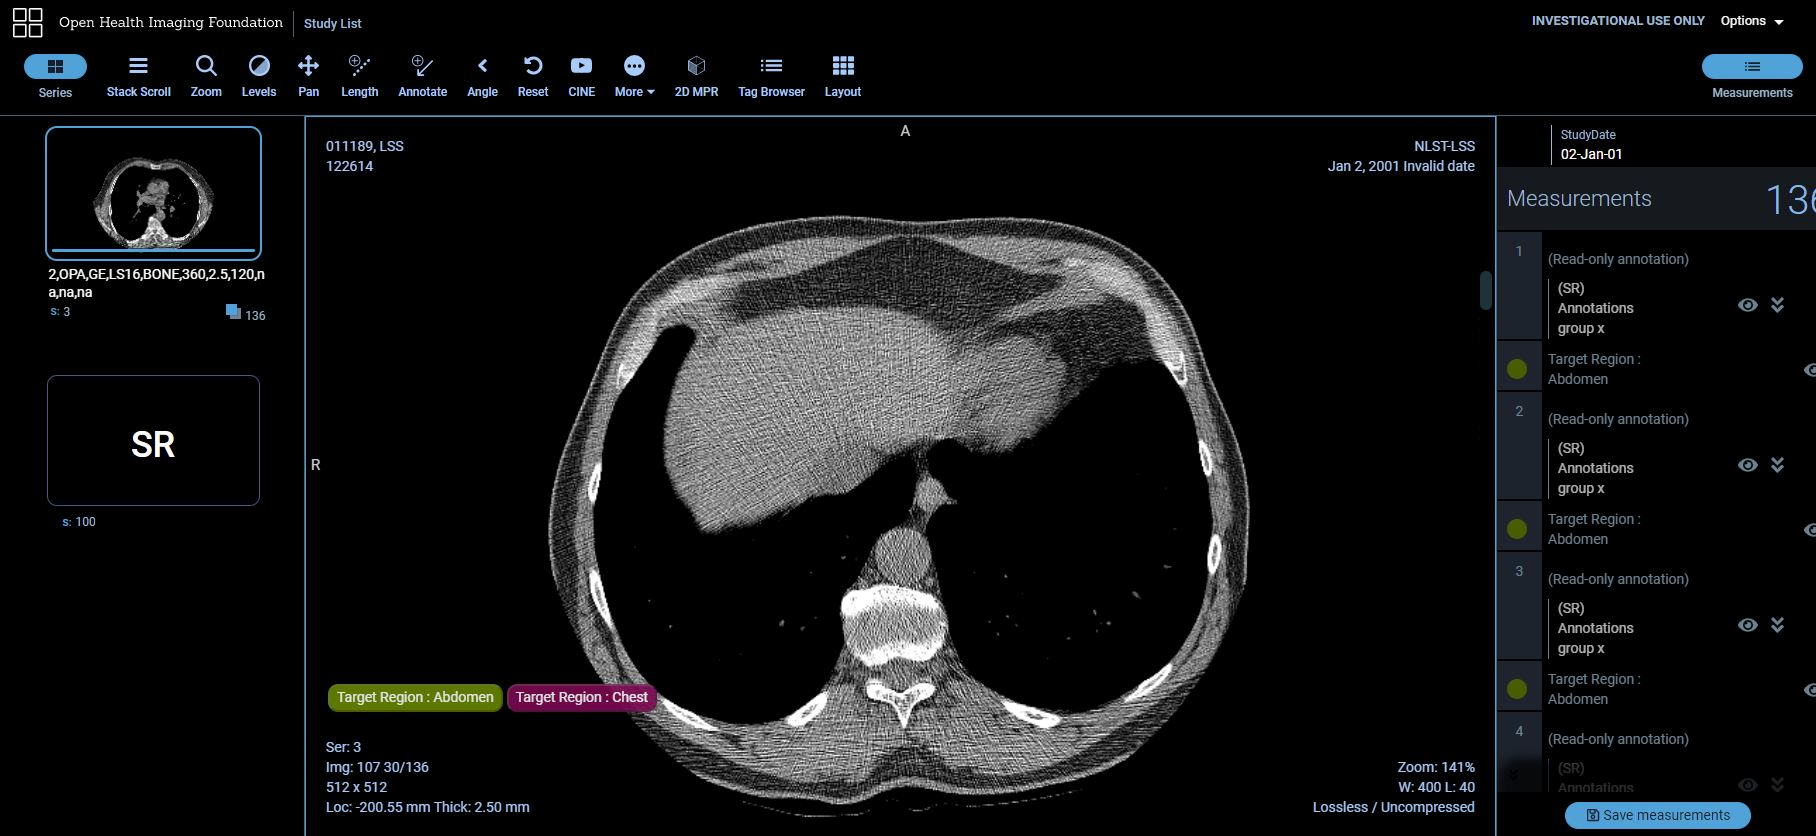

**Extra steps to view in 2 dicom store: We do not yet have documentation for user to display an OHIF viewer with this functionality. **

In [ ]:
my_bucket_sr_only = 'bpr_pw37_bucket_sr_only'
my_datastore_sr_only = 'bpr_pw37_datastore_sr_only'

# Create bucket to store only SR 
!gsutil mb -p $project_name gs://$my_bucket_sr_only

# Copy SRs from here to bucket 
!gsutil -m cp '/content/SR/*' gs://$my_bucket_sr_only

# Create datastore to store only SR 
!gcloud healthcare dicom-stores create $my_datastore_sr_only --project $project_name --dataset $my_dataset --format="value(ID)" 

# Copy from bucket to datatore
!gcloud healthcare dicom-stores import gcs $my_datastore_sr_only \
                                            --dataset=$my_dataset \
                                            --location=$location_id \
                                            --project=$project_name \
                                            --gcs-uri=gs://$my_bucket_sr_only/**.dcm

# Delete the bucket and its contents as we are done using 
!gsutil -m rm -r gs://$my_bucket_sr_only

Creating gs://bpr_pw37_bucket_sr_only/...
Copying file:///content/SR/1.2.840.113654.2.55.150829114069322743366190970497756109939.dcm [Content-Type=application/dicom]...
Copying file:///content/SR/1.2.840.113654.2.55.90227613890304869571054246182139624020.dcm [Content-Type=application/dicom]...
Copying file:///content/SR/1.2.840.113654.2.55.102063843464126214499301760425586588683.dcm [Content-Type=application/dicom]...
\
Operation completed over 3 objects/436.3 KiB.                                    
Created dicomStore [bpr_pw37_datastore_sr_only].

Request issued for: [bpr_pw37_datastore_sr_only]
name: projects/idc-external-018/locations/us-central1/datasets/bpr_pw37_dataset/dicomStores/bpr_pw37_datastore_sr_only


In [ ]:
# Get the studyInstanceUID and form url for IDC viewer: 

query = """
        SELECT 
          DISTINCT(StudyInstanceUID),
          SeriesInstanceUID
        FROM
          `bigquery-public-data.idc_current.dicom_all`
        WHERE
          SeriesInstanceUID IN UNNEST(@SeriesInstanceUID_list);
        """

client = bigquery.Client(project=project_name)
job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ArrayQueryParameter("SeriesInstanceUID_list", "STRING", SeriesInstanceUID_list)
                                                       ])
result = client.query(query, job_config=job_config) 
studies_df = result.to_dataframe()
studies_df

# Form the three urls: 
def form_two_server_url(StudyInstanceUID, project_id, location_id, dataset_id, datastore_id):

  url1 = "https://idc2serversdeploy-3c769.web.app/viewer"
  url = os.path.join(url1, 
                     StudyInstanceUID + '!secondGoogleServer=',
                     'projects', project_id,
                     'locations', location_id,
                     'datasets', dataset_id, 
                     'dicomStores', datastore_id) 
  
  return url 


StudyInstanceUID_list = studies_df['StudyInstanceUID'].values 

for n in range(0,3):
  url = form_two_server_url(StudyInstanceUID_list[n], 
                            project_name, 
                            location_id, 
                            my_dataset, 
                            my_datastore_sr_only) 
  print(url)
                            


https://idc2serversdeploy-3c769.web.app/viewer/1.2.840.113654.2.55.102953526081307798259585998827865858701!secondGoogleServer=/projects/idc-external-018/locations/us-central1/datasets/bpr_pw37_dataset/dicomStores/bpr_pw37_datastore_sr_only
https://idc2serversdeploy-3c769.web.app/viewer/1.2.840.113654.2.55.306866458568443630966835067475056722880!secondGoogleServer=/projects/idc-external-018/locations/us-central1/datasets/bpr_pw37_dataset/dicomStores/bpr_pw37_datastore_sr_only
https://idc2serversdeploy-3c769.web.app/viewer/1.2.840.113654.2.55.180027619411798970800803727667566025874!secondGoogleServer=/projects/idc-external-018/locations/us-central1/datasets/bpr_pw37_dataset/dicomStores/bpr_pw37_datastore_sr_only
